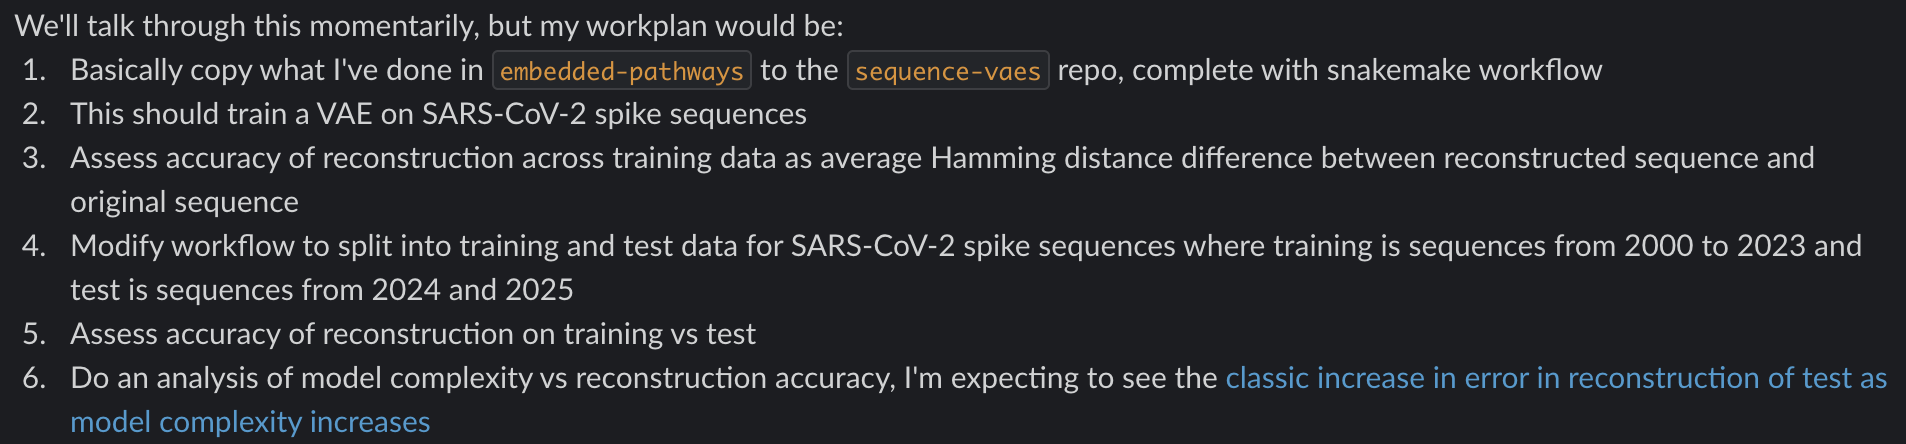

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys

%cd "/content/drive/MyDrive/bedford_lab/code/embedded-pathways"
!pip install -r requirements.txt

In [ ]:
sys.path.append("/content/drive/MyDrive/bedford_lab/code/embedded-pathways/latent-diffusion")
from models import VAE, DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_dim, latent_dim, non_linear_activation):
    super().__init__()
    self.input_channels = len(ALPHABET)
    self.input_dim = input_dim
    self.latent_dim = latent_dim
    self.non_linear_activation = non_linear_activation

    self.seq_len = input_dim
    self.conv_depth = 3
    self.convolve = nn.Conv1d(self.input_channels, self.conv_depth, kernel_size=1)

    self.encode = nn.Sequential(
      nn.Linear(self.conv_depth * self.seq_len, 1024),
      self.non_linear_activation,
      nn.Linear(1024, 512),
      self.non_linear_activation
    )
    self.fc_mean = nn.Linear(512, self.latent_dim)
    self.fc_logvar = nn.Linear(512, self.latent_dim)

  def forward(self, x):
    x = x.permute((0,2,1))
    x = self.convolve(x)
    x = x.view(-1, self.conv_depth * self.seq_len)
    x = self.encode(x)
    mean = self.fc_mean(x)
    log_var = self.fc_logvar(x)
    return mean, log_var

In [ ]:
class Decoder(nn.Module):
  def __init__(self, input_dim, latent_dim, non_linear_activation):
    super().__init__()
    self.input_channels = len(ALPHABET)
    self.input_dim = input_dim
    self.latent_dim = latent_dim
    self.non_linear_activation = non_linear_activation

    self.means = nn.ModuleList([
      nn.Linear(self.latent_dim, 512),
      nn.Linear(512,1024),
      nn.Linear(1024, self.input_dim * self.input_channels) # last layer
    ])

    self.log_var = nn.ModuleList([
      nn.Linear(self.latent_dim, 512),
      nn.Linear(512,1024),
    ])

    for (mu,lvar) in zip(self.means, self.log_var):
      nn.init.constant_(mu.bias,0.1)
      nn.init.constant_(lvar.weight,-10.0)
      nn.init.constant_(lvar.bias,-10.0)

  def sampler(self, mean, log_var):
    eps = torch.randn_like(mean)
    return (torch.exp(0.5 * log_var) * eps) + mean

  def forward(self, x):
    for i in range(2):
      W_mu = self.means[i]
      W_lvar = self.log_var[i]
      W = self.sampler(W_mu.weight, W_lvar.weight)
      b = self.sampler(W_mu.bias, W_lvar.bias)
      x = self.non_linear_activation(F.linear(input=x, weight=W, bias=b))

    x = F.linear(input=x, weight=self.means[-1].weight, bias=self.means[-1].bias)
    x = x.view(-1,self.input_dim, self.input_channels)
    x = F.log_softmax(x, dim=-1)
    return x

In [ ]:
class VAE(nn.Module):
  def __init__(self, input_dim, latent_dim):
    super().__init__()
    self.input_dim = input_dim
    self.latent_dim = latent_dim
    self.non_linear_activation = nn.ReLU()

    self.encoder = Encoder(input_dim, latent_dim, self.non_linear_activation)
    self.decoder = Decoder(input_dim, latent_dim, self.non_linear_activation)

  def sample_latent(self, mean, log_var):
    eps = torch.randn_like(mean)
    std = torch.exp(0.5 * log_var)
    return torch.mul(eps, std) + mean

  def train_vae(self, dataloader, epochs, optimizer):
    mse_loss = nn.MSELoss()
    for epoch in range(epochs):
      self.train()
      epoch_loss = 0.0
      epoch_recon_loss = 0.0
      epoch_kl_loss = 0.0
      for i, record_set in enumerate(dataloader):
        batch, _ = record_set  # Unpack sequence tensor and record_id
        batch = batch.to(DEVICE)
        # batch = batch.view(batch.size(0), -1).to(DEVICE)  # Flatten one-hot sequences

        # Train VAE
        mean, logvar = self.encoder.forward(batch)
        z = self.sample_latent(mean, logvar)
        recon = self.decoder.forward(z)

        # recon_loss = mse_loss(recon, batch)
        recon_loss = nn.functional.binary_cross_entropy_with_logits(recon, batch, reduction='sum') / batch.shape[0]
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / batch.shape[0]
        beta = 0.1  # tunable parameter
        vae_loss = recon_loss + beta * kl_loss

        optimizer.zero_grad()
        vae_loss.backward()
        optimizer.step()

        epoch_loss += vae_loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()

      print(f"Epoch {epoch+1}/{epochs} - VAE Loss: {epoch_loss / len(dataloader):.4f} - Reconstruction Loss: {epoch_recon_loss / len(dataloader):.4f} - KL Loss: {epoch_kl_loss / len(dataloader):.4f}")

In [ ]:
BATCH_SIZE = 64
EPOCHS = 30

dataset = DNADataset("/content/drive/MyDrive/bedford_lab/code/embedded-pathways/data/alignment.fasta")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [ ]:
# input_dim = len(ALPHABET) * SEQ_LENGTH
input_dim = 29903
vae_model = VAE(input_dim=input_dim, latent_dim=LATENT_DIM).to(DEVICE)

In [ ]:
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-4)
vae_model.train_vae(dataloader, EPOCHS, optimizer)

Epoch 1/30 - VAE Loss: 69910.1997 - Reconstruction Loss: 69434.0762 - KL Loss: 4761.2457
Epoch 2/30 - VAE Loss: 39109.2900 - Reconstruction Loss: 38233.8977 - KL Loss: 8753.9251
Epoch 3/30 - VAE Loss: 23141.4348 - Reconstruction Loss: 22370.9597 - KL Loss: 7704.7503
Epoch 4/30 - VAE Loss: 21437.3320 - Reconstruction Loss: 21097.8032 - KL Loss: 3395.2903
Epoch 5/30 - VAE Loss: 21236.5603 - Reconstruction Loss: 21030.5464 - KL Loss: 2060.1374
Epoch 6/30 - VAE Loss: 21175.9805 - Reconstruction Loss: 21011.7827 - KL Loss: 1641.9757
Epoch 7/30 - VAE Loss: 21133.6362 - Reconstruction Loss: 21003.5129 - KL Loss: 1301.2337
Epoch 8/30 - VAE Loss: 21107.2454 - Reconstruction Loss: 21005.7310 - KL Loss: 1015.1478
Epoch 9/30 - VAE Loss: 21094.3970 - Reconstruction Loss: 21007.8240 - KL Loss: 865.7328
Epoch 10/30 - VAE Loss: 21085.7363 - Reconstruction Loss: 21002.1069 - KL Loss: 836.2964
Epoch 11/30 - VAE Loss: 21080.4441 - Reconstruction Loss: 20999.9453 - KL Loss: 804.9890
Epoch 12/30 - VAE Loss

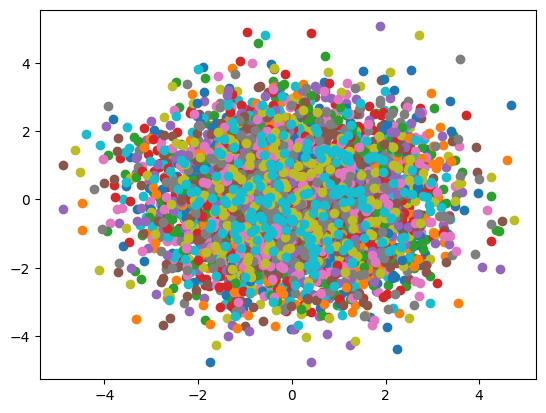

In [ ]:
for j in range(3):
  X, _ = next(iter(dataloader))
  X = X.to(DEVICE)
  # X = X.view(X.size(0), -1).to(DEVICE)
  pca = PCA(n_components=2)
  with torch.no_grad():
    Z_mean, Z_logvar = vae_model.encoder.forward(X)
    Z_mean = Z_mean.cpu()
    Z_std = torch.exp(0.5 * Z_logvar).cpu()

    for i in range(10):
      eps = np.random.normal(0,1,(200,80))
      eps = np.add(np.multiply(eps,Z_std[i]), Z_mean[i])

      X_embedded_pca = pca.fit_transform(eps)
      plt.scatter(X_embedded_pca[:,0], X_embedded_pca[:,1], label="%d"%i)
plt.show()